# Fraud Detection System - V1: Exploratory Data Analysis (EDA)

**Date:** 2026-01-24    
**Author:** *Luis Renteria Lezano*  
[LinkedIn](https://www.linkedin.com/in/renteria-luis) | [GitHub](https://github.com/renteria-luis)

## Executive Summary
- **Goal:** Understand the key factors influencing **fraudulent transactions** in credit card operations and prepare **clean, structured data** suitable for building **baseline and advanced classification models**. The focus is on **detecting anomalies**, **identifying patterns of fraud**, and creating a **robust dataset** that can support **machine learning algorithms** for **real-time fraud detection**. Special attention is given to the **highly imbalanced target class**, ensuring proper handling of **rare fraudulent cases** during model training and evaluation.
- **Source:** This analysis uses the Credit Card Fraud Detection dataset published on [Kaggle by MLG ULB](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data).
- **Data:** [`../data/raw/creditcard.csv`](../data/raw/creditcard.csv).
- **Target variable:** `Class`:
    - 0 = legitimate transaction
    - 1 = fraudulent transaction

## 1. Reproducibility & Environment Setup
- Pin versions in [`../requirements.txt`](../).
- Keep raw data immutable [`../data/raw/`](../data/raw/).

In [1]:
%reload_ext autoreload
%autoreload 2

import sys
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ks_2samp

from sklearn.model_selection import train_test_split

sys.path.append('..')
from src.features import FeatureEngineering

# 1. Global Reproducibility
SEED = 42
np.random.seed(SEED)

# 2. Path Management
BASE_DIR = Path("..")
ASSETS_DIR = Path('../assets/figures')
DATA_RAW = BASE_DIR / "data" / "raw"
DATA_PROCESSED = BASE_DIR / "data" / "processed"
MODELS_DIR = BASE_DIR / "models"
MODELS_DIR = BASE_DIR / "models"

# 3. Plotting Style
sns.set_theme(style='whitegrid', context='notebook', palette='viridis')
plt.rcParams["figure.figsize"] = (10, 6)

# 4. Global Settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 2. Data Loading & Overview
### 2.1 Load Data

In [2]:
raw_file = DATA_RAW / 'PS_20174392719_1491204439457_log.csv'
df = pd.read_csv(raw_file)

### 2.2 Dataset Shape & Info

In [3]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### 2.3 First Rows Preview

In [4]:
df.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0,0
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1,0


### 2.4 Feature Exploration

In [5]:
for col in df.columns:
    # Ignore floats
    if pd.api.types.is_float_dtype(df[col]):
        continue
    n_unique = df[col].nunique()
    
    if n_unique > 10:
        print(f"{col}: high cardinality ({n_unique} unique values)")
    else:
        print(f"{col}: {n_unique} unique values -> {df[col].unique()}")

step: high cardinality (743 unique values)
type: 5 unique values -> ['PAYMENT' 'TRANSFER' 'CASH_OUT' 'DEBIT' 'CASH_IN']
nameOrig: high cardinality (6353307 unique values)
nameDest: high cardinality (2722362 unique values)
isFraud: 2 unique values -> [0 1]
isFlaggedFraud: 2 unique values -> [0 1]


**Findings (PaySim 1):**

* `step`: time step in hours since the first transaction.
* `type`: type of transaction (*CASH-IN*, *CASH-OUT*, *TRANSFER*, *DEBIT*, *PAYMENT*).
* `amount`: transaction amount.
* `nameOrig`: ID of the customer who initiates the transaction (high cardinality -> dropped).
* `nameDest`: ID of the customer who receives the transaction (high cardinality -> dropped).
* `oldbalanceOrg`: balance of the origin account before the transaction.
* `newbalanceOrig`: balance of the origin account after the transaction (data leakage -> dropped).
* `oldbalanceDest`: balance of the destination account before the transaction.
* `newbalanceDest`: balance of the destination account after the transaction (data leakage -> dropped).
* `isFraud`: 0 (legitimate) / 1 (fraud).
* `isFlaggedFraud`: 0/1, automatically flagged by business rules (rare, mostly 0 -> dropped).

In [6]:
duplicates = df.duplicated().sum()

if duplicates > 0:
    print(f'There are {duplicates} duplicated rows in the dataset.')
    df = df.drop_duplicates()
else:
    print('There are no duplicates in the dataset.')

There are no duplicates in the dataset.


## 3. Data Quality Assessment
### 3.1 Missing Values

In [7]:
missing_per_col = df.isna().sum()

if missing_per_col.sum() > 0:
    missing_per_col[missing_per_col > 0].sort_values(ascending=False).head()
else:
    print('There are no missing values in the dataset.')

There are no missing values in the dataset.


### 3.2 Duplicated Values

In [8]:
duplicates = df.duplicated().sum()

if duplicates > 0:
    print(f'There are {duplicates} duplicated rows in the dataset.')
    df = df.drop_duplicates()
else:
    print('There are no duplicates in the dataset.')

There are no duplicates in the dataset.


## 4. Target Variable Analysis (Class Imbalance)
### 4.1 Class Distribution

In [9]:
counts = df['isFraud'].value_counts()
percent = df['isFraud'].value_counts(normalize=True) * 100

summary = pd.DataFrame({
    'Count': counts,
    'Percentage': percent
}).reset_index()

summary.rename(columns={'index': 'isFraud'}, inplace=True)
summary

,isFraud,Count,Percentage
0,0,6354407,99.871
1,1,8213,0.129


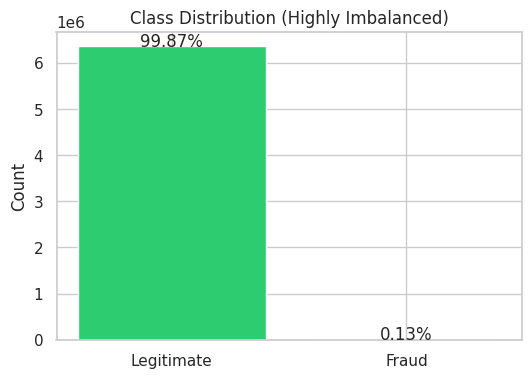

In [10]:
fig, ax = plt.subplots(figsize=(6,4))

class_counts = df['isFraud'].value_counts()
class_counts = class_counts.reindex([0,1])

ax.bar(['Legitimate', 'Fraud'], class_counts.values, color=['#2ecc71', '#e74c3c'])
ax.set_ylabel('Count')
ax.set_title('Class Distribution (Highly Imbalanced)')

for i, count in enumerate(class_counts.values):
    pct = 100 * count / class_counts.values.sum()
    ax.text(i, count + 100, f"{pct:.2f}%", ha='center')

# plt.savefig(ASSETS_DIR / 'class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
# plt.close()

### 4.2 Imbalance Ratio

In [18]:
# imbalance_ratio = legitimate / fraud
print(f"For every fraudulent transaction, there are {int(summary.loc[0, 'Count'] / summary.loc[1, 'Count'])} legitimate transactions.")

For every fraudulent transaction, there are 773 legitimate transactions.


**Implication for modeling:**
- Accuracy is useless metric (99.8% by predicting all 0)
- Focus on Precision, Recall, F1, ROC-AUC, AUPRC
- Stratified split essential



## 5. Feature Analysis
### 5.1. Type feature

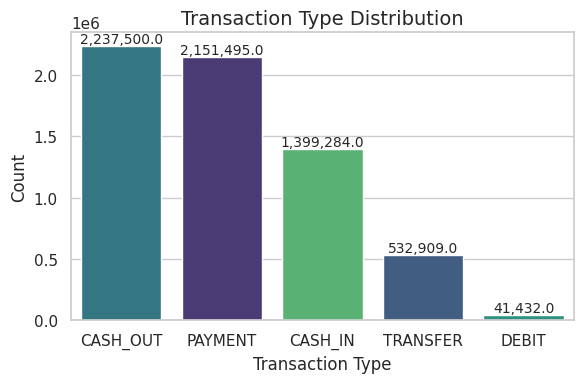

In [23]:
plt.figure(figsize=(6,4))
sns.countplot(
    data=df,
    x='type',
    hue='type',
    order=df['type'].value_counts().index  # sorts
)
plt.title('Transaction Type Distribution', fontsize=14)
plt.xlabel('Transaction Type', fontsize=12)
plt.ylabel('Count', fontsize=12)

# show counts
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().annotate(f'{height:,}', 
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

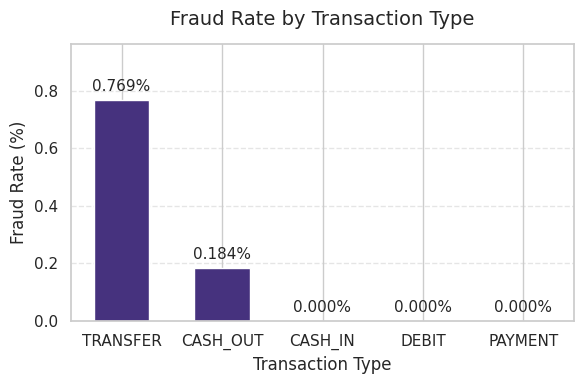

In [35]:
fraud_rate = (
    df.groupby("type")["isFraud"]
    .mean()
    .mul(100)
    .reset_index()
    .rename(columns={"isFraud": "fraud_pct"})
    .sort_values("fraud_pct", ascending=False)
)

fig, ax = plt.subplots(figsize=(6, 4))
bars = ax.bar(fraud_rate["type"], fraud_rate["fraud_pct"], width=0.55)

for bar, val in zip(bars, fraud_rate["fraud_pct"]):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        f"{val:.3f}%",
        ha="center", va="bottom",
        fontsize=11
    )

ax.set_title("Fraud Rate by Transaction Type", fontsize=14, pad=14)
ax.set_xlabel("Transaction Type", fontsize=12)
ax.set_ylabel("Fraud Rate (%)", fontsize=12)
ax.set_ylim(0, fraud_rate["fraud_pct"].max() * 1.25)
ax.grid(axis="y", linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()

**Insight:**

* **TRANSFER transactions** have the highest fraud rate at **0.769%**, even though they are less frequent than CASH-OUT or PAYMENT.
* **CASH-OUT transactions** also show some fraud, at **0.184%**, but lower than TRANSFER.
* **CASH-IN, PAYMENT, and DEBIT** transactions have **0% fraud**, meaning no fraudulent activity was observed in these categories.

**Action:**

* The records corresponding to **CASH-IN, PAYMENT, and DEBIT** will be removed from the dataset, since they contain no fraud and do not contribute to modeling or detecting fraud.
* After removing CASH-IN, PAYMENT, and DEBIT, we are left with **2,770,409 records**.

In [47]:
df = df[df['type'].isin(['TRANSFER', 'CASH_OUT'])]
print(f"For every fraudulent transaction, there are {(df['isFraud'] == 0).sum() / (df['isFraud'] == 1).sum()} legitimate transactions.")

For every fraudulent transaction, there are 336.3199805186899 legitimate transactions.


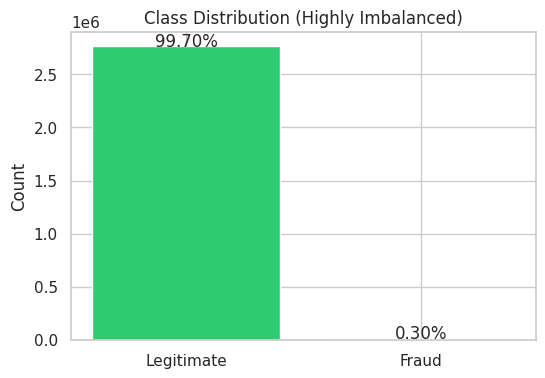

In [48]:
fig, ax = plt.subplots(figsize=(6,4))

class_counts = df['isFraud'].value_counts()
class_counts = class_counts.reindex([0,1])

ax.bar(['Legitimate', 'Fraud'], class_counts.values, color=['#2ecc71', '#e74c3c'])
ax.set_ylabel('Count')
ax.set_title('Class Distribution (Highly Imbalanced)')

for i, count in enumerate(class_counts.values):
    pct = 100 * count / class_counts.values.sum()
    ax.text(i, count + 100, f"{pct:.2f}%", ha='center')

plt.savefig(ASSETS_DIR / 'class_distribution.png', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

### 5.2 Time feature

In [ ]:
df['hour_of_day'] = df['step'] % 24
df['day'] = df['step'] // 24

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# hourly
sns.kdeplot(
    data=df, x='hour_of_day', hue='isFraud',
    common_norm=False, fill=True, alpha=0.4,
    hue_order=[0, 1], palette={0: 'blue', 1: 'red'}, ax=axes[0]
)
axes[0].set_title('Intraday Cycle (Hour of Day)')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Density')
axes[0].legend(labels=['Fraud', 'Legitimate'])

# daily
sns.kdeplot(
    data=df, x='day', hue='isFraud',
    common_norm=False, fill=True, alpha=0.4,
    hue_order=[0, 1], palette={0: 'blue', 1: 'red'}, ax=axes[1]
)
axes[1].set_title('Daily Distribution (30 days)')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Density')
axes[1].legend(labels=['Fraud', 'Legitimate'])

plt.tight_layout()
plt.show()